- 3-layer Bi-directional LSTM encoder
- 1-layer uni-directional LSTM decoder
- 50 epochs
- Dropout

In [ ]:
!pip install nltk==3.5 # required to calculate meteor scores

In [ ]:
# Test Summarization with LSTM
# Author: Xuan Lin

# Save output to a file
import sys
import datetime as dt

master_ts = dt.datetime.now() - dt.timedelta(hours = 5)
ts_filename = format(master_ts, "%m%d%H%M")

print("Deep Learning Group Project - Text Summarization")
print("Author: Niharika Tyagi")
print("")
print("File timestamp: {}".format(ts_filename))
print("")

# ------------------- Hyper-Parameters --------------------

weights_to_load = ''
print("Load model weights from {}".format(weights_to_load))

params = dict({'title': '3L50eDO(0.2)',
               'n_epoch':50,
              'batch_size': 500,
              'optimizer': 'adam',
              'loss_fun': 'sparse_categorical_crossentropy', # categorical_crossentropy
              'max_len_text': 80,
              'max_len_summary': 8,
              'patience': 3,
              'dropout': 0.2,
              'rec_dropout': 0
              })
print("Hyper-parameters: {}".format(params))
print("")

# ---------------------- Load Packages -------------------------

#import pkg_resources
#pkg_resources.require("nltk==3.5")
import pandas as pd
import numpy as np
import re
from gensim import models
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings("ignore")
import nltk
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
#nltk.download('stopwords')
from Attention import AttentionLayer

import tensorflow as tf
tf.random.set_seed(2020)

print("Packages Loaded.")
print("")


# --------------------- Load data ------------------------

#path = '/content/drive/My Drive/'
#df = pd.read_csv(path + "Copy of Reviews Cleaned.csv")
full_path = '/content/drive/My Drive/'

#print("Dataset Size: {}".format(df.shape))
#print("")

max_len_text = params['max_len_text']
max_len_summary = params['max_len_summary']

# Load train, val, and test data from csv files
train = pd.read_csv(full_path+'TrainSet.csv', nrows = 100)
val = pd.read_csv(full_path+'ValSet.csv', nrows = 50)
test= pd.read_csv(full_path+'TestSet80k.csv', nrows = 50)

train_id, Xtrain, ytrain = train['id'], train['text'].astype('str'), train['summary'].astype('str')
val_id, Xval, yval = val['id'], val['text'].astype('str'), val['summary'].astype('str')
test_id, Xtest, ytest = test['id'], test['text'].astype('str'), test['summary'].astype('str')
y_true = ytest

"""
# Train Test Split
Xtrain, Xtest, ytrain, ytest = train_test_split(df[['Id','cleaned_text']].astype('str'),
                                              df['cleaned_summary'].astype('str'),
                                              test_size=0.2,random_state = 2020)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size = 0.1, random_state = 2020)
train_id, Xtrain = Xtrain['Id'], Xtrain['cleaned_text']
val_id, Xval = Xval['Id'], Xval['cleaned_text']
test_id, Xtest = Xtest['Id'], Xtest['cleaned_text']
y_true = ytest
"""

print("Train X & y: ", Xtrain.shape, ytrain.shape)
print("Validation X & y: ", Xval.shape, yval.shape)
print("Test X & y: ", Xtest.shape, ytest.shape)
print("")

# ---------------------- Tokenization ----------------------

# Review
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(Xtrain))
Xtrain = x_tokenizer.texts_to_sequences(Xtrain) 
Xval = x_tokenizer.texts_to_sequences(Xval)
Xtest = x_tokenizer.texts_to_sequences(Xtest)

Xtrain = pad_sequences(Xtrain, maxlen=max_len_text, padding='post')
Xval = pad_sequences(Xval, maxlen=max_len_text, padding='post')
Xtest = pad_sequences(Xtest, maxlen=max_len_text, padding='post')
x_voc_size = len(x_tokenizer.word_index) + 1

print("Review tokenization and padding done.")


# Summary
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(ytrain))

ytrain = y_tokenizer.texts_to_sequences(ytrain)
yval = y_tokenizer.texts_to_sequences(yval)
ytest = y_tokenizer.texts_to_sequences(ytest) 

ytrain = pad_sequences(ytrain, maxlen=max_len_summary, padding='post')
yval = pad_sequences(yval, maxlen=max_len_summary, padding='post')
ytest = pad_sequences(ytest, maxlen=max_len_summary, padding='post')
y_voc_size = len(y_tokenizer.word_index) +1

print("Summary tokenization and padding done.")
print("")

#print("Sample Review: {}".format(Xtrain[0]))


# --------------------- Load Pre-Trained Embeddings -----------------

# Load Dictionary

latent_dim = 200
glove_path = full_path+'glove.6B.200d.txt'
f = open(glove_path)

# Input lines of the GloVe file into the embedding index dictionary
embeddings_index = dict()
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype = 'float32')
  embeddings_index[word] = coefs
f.close

print("Loaded {} 200-Dimension word vectors.".format(len(embeddings_index)))


# Construct Text Embedding Layer

enc_embedding_matrix = np.zeros((x_voc_size, latent_dim))

for word, i in x_tokenizer.word_index.items():  # extract weights from GloVe
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    enc_embedding_matrix[i] = embedding_vector


# Construct Summary Embedding Layer

dec_embedding_matrix = np.zeros((y_voc_size, latent_dim))

for word, i in y_tokenizer.word_index.items():  # extract weights from GloVe
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    dec_embedding_matrix[i] = embedding_vector





Deep Learning Group Project - Text Summarization
Author: Xuan Lin

File timestamp: 06041348

Load model weights from 
Hyper-parameters: {'title': '3L50eDO(0.2)', 'n_epoch': 50, 'batch_size': 500, 'optimizer': 'adam', 'loss_fun': 'sparse_categorical_crossentropy', 'max_len_text': 80, 'max_len_summary': 8, 'patience': 3, 'dropout': 0.2, 'rec_dropout': 0}



Using TensorFlow backend.


Packages Loaded.

Train X & y:  (100,) (100,)
Validation X & y:  (50,) (50,)
Test X & y:  (50,) (50,)

Review tokenization and padding done.
Summary tokenization and padding done.

Loaded 400000 200-Dimension word vectors.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# ------------------ LSTM Training Model -------------------


from keras import backend as K
K.clear_session()

# Encoder ----------

# Inputs are review entries, which has 80 words max
encoder_input = Input(shape=(max_len_text,))
# Create an embedding layer to be trained, input_dim = number of volcabularies/tokens
# output_dim is the dim of the encoded vector
enc_emb = Embedding(x_voc_size, latent_dim, weights = [enc_embedding_matrix], trainable = False)(encoder_input)

# LSTM Layer 1
# return_sequence: returns hidden state and cell state of every timestamp
# return_state: produce hidden state and cell state of the last timestamp only
encoder_lstm1 = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True,
                     activation='tanh', 
                     dropout = params['dropout'], recurrent_dropout = params['rec_dropout']))
encoder_output1, foward_h1, forward_c1, backward_h1, backward_c1 = encoder_lstm1(enc_emb)

# LSTM Layer 2
encoder_lstm2 = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True, 
                     dropout = params['dropout'], recurrent_dropout = params['rec_dropout']))
encoder_output2, foward_h2, forward_c2, backward_h2, backward_c2 = encoder_lstm2(encoder_output1)

# LSTM Layer 3
encoder_lstm3 = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True, 
                     dropout = params['dropout'], recurrent_dropout = params['rec_dropout']))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm3(encoder_output2)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])


# Decoder ----------

decoder_input = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc_size, latent_dim, weights = [dec_embedding_matrix], trainable = False)
dec_emb = dec_emb_layer(decoder_input)

# LSTM
decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True,
                    dropout = params['dropout'], recurrent_dropout = params['rec_dropout'])
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,
                                                                      initial_state=[state_h, state_c])

# Attention Layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention output and decoder LSTM output horizontally
decoder_concat_input = Concatenate(axis = -1, name = 'concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation = 'softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)


# Model -----------

# Define the model
model = Model([encoder_input, decoder_input], decoder_outputs)
print("")
print("------------------ Training Model -------------------")
print("")
model.summary()
if weights_to_load != '':
  model.load_weights(full_path+weights_to_load)



------------------ Training Model -------------------

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 200)      334400      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 80, 400), (N 641600      embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 80, 400), (N 961600      bidirectional[0][0]              
______________________________________

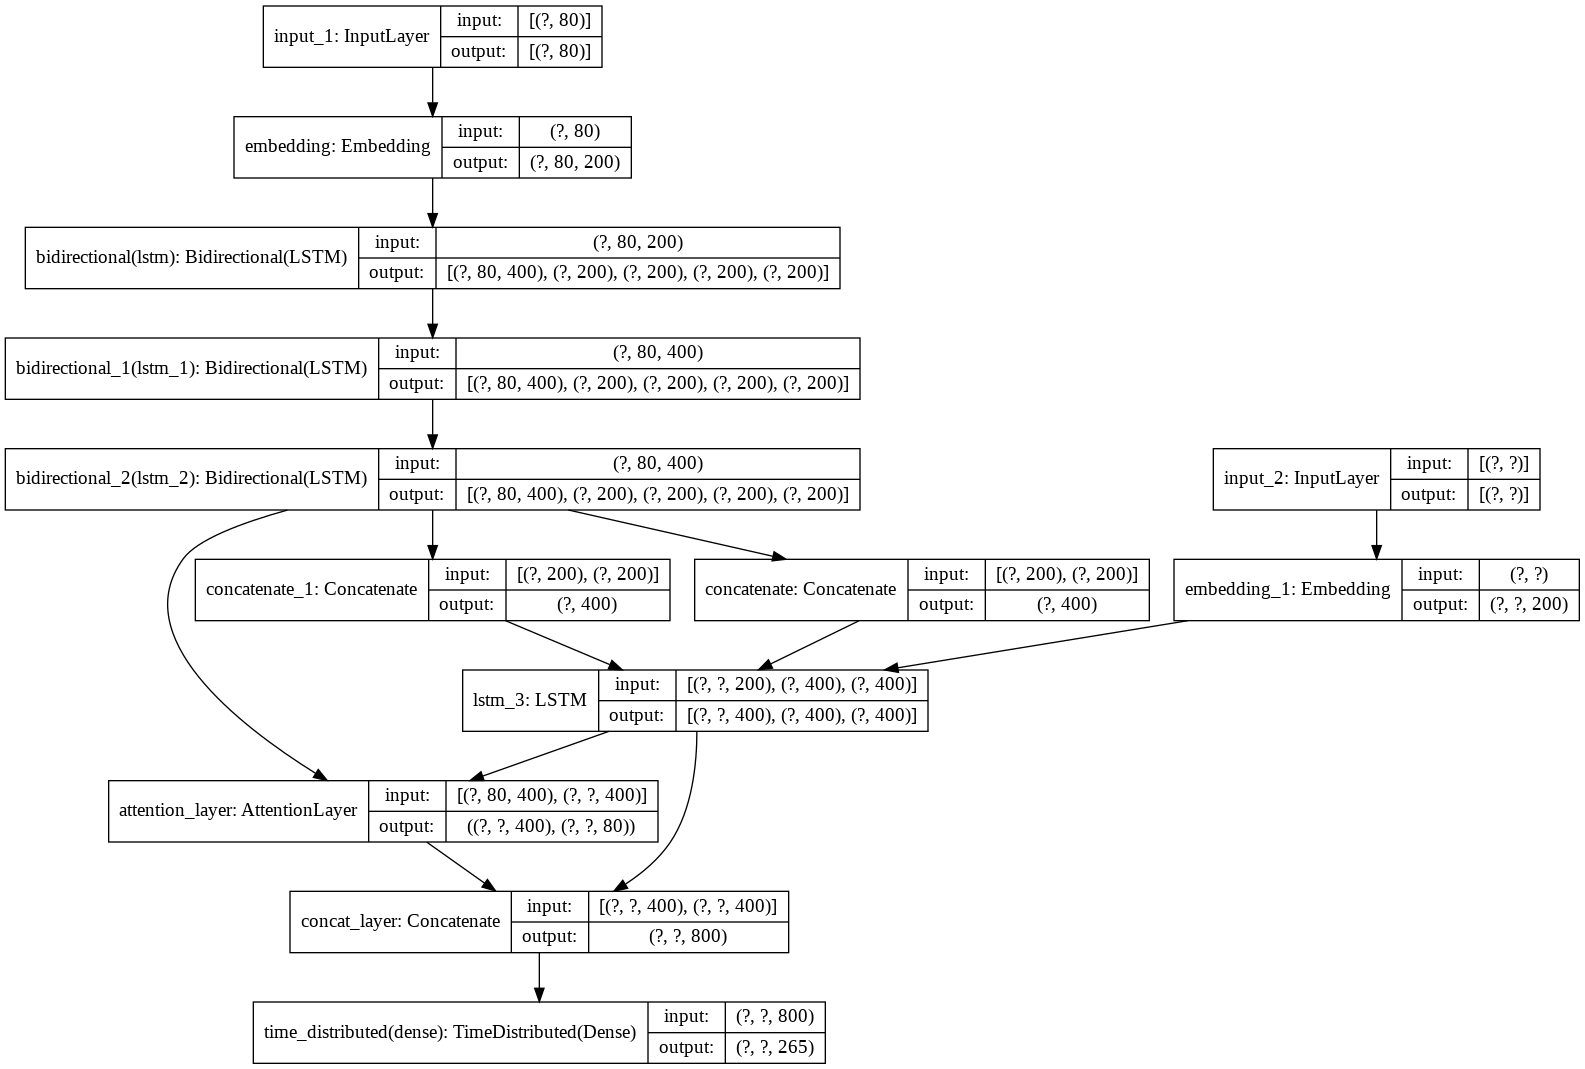

In [ ]:
plot_model(model,show_shapes=True)

In [ ]:
# Training -----------

start_ts = dt.datetime.now()-dt.timedelta(hours=5)
print("Training starts at {}".format(start_ts))

model.compile(optimizer=params['optimizer'], loss=params['loss_fun'])
es = EarlyStopping(monitor='val_loss', mode = 'min', verbose=1, patience = params['patience'], restore_best_weights=True)
history=model.fit([Xtrain, ytrain[:,:-1]], 
                  ytrain.reshape(ytrain.shape[0], ytrain.shape[1], 1)[:,1:],
                  epochs=2, callbacks=[es], batch_size = params['batch_size'], 
                  validation_data=([Xval, yval[:,:-1]], yval.reshape(yval.shape[0],yval.shape[1], 1)[:,1:]))

end_ts = dt.datetime.now()-dt.timedelta(hours=5)
print("Training ends at {}".format(end_ts))
print("Training Time: {}".format(end_ts - start_ts))
print("")


Training starts at 2020-06-04 13:51:20.204282
Epoch 1/2
1/1 [==============================] - 3s 3s/step - loss: 3.6233 - val_loss: 2.2389
Epoch 2/2
1/1 [==============================] - 1s 867ms/step - loss: 4.6195 - val_loss: 1.9942
Training ends at 2020-06-04 13:51:46.512553
Training Time: 0:00:26.308271



In [ ]:

# Save results -----------

# Save weights
model.save_weights(full_path+'LSTM_weights_'+ts_filename+'.h5')
print("Weights saved.")
print("")

# Save CV results
pd.DataFrame(history.history).to_csv(full_path+'LSTM_history_'+str(ts_filename)+'.csv', index = False)

# Save image
loss_plot = plt.figure()
train_loss, val_loss = history.history['loss'], history.history['val_loss']
plt.plot(history.epoch, train_loss, color = "black")
plt.plot(history.epoch, val_loss, color = "blue")
plt.title("Training and Validation Loss")
plt.legend(['Train', 'Validation'])
#plt.show()
loss_plot.savefig(full_path+'LSTM_loss_'+str(ts_filename)+'.jpg')
plt.close(loss_plot)

print("CV results saved.")
print("")
print("")


# --------------------- LSTM Inference Model -------------------

print("------------------ Inference Model -------------------")

reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

# Encoder Inference
encoder_model = Model(inputs=encoder_input,
                      outputs = [encoder_outputs, forward_h, forward_c, backward_h, backward_c])

# Decoder inference
decoder_state_input_forward_h = Input(shape=(latent_dim,))
decoder_state_input_forward_c = Input(shape=(latent_dim,))
decoder_state_input_backward_h = Input(shape=(latent_dim,))
decoder_state_input_backward_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text, latent_dim*2))

state_h_inf = Concatenate()([decoder_state_input_forward_h, decoder_state_input_backward_h])
state_c_inf = Concatenate()([decoder_state_input_forward_c, decoder_state_input_backward_c])

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_input)

# Predict the next word
# set the initial state to the previous state
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2,
                                                   initial_state = [state_h_inf, state_c_inf])

# Attention Inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])

# Concatenate attention output and decoder output
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Softmax layer to output probability distribution
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(inputs = [decoder_input]+[decoder_hidden_state_input, 
                                                decoder_state_input_forward_h, decoder_state_input_forward_c,
                                                decoder_state_input_backward_h, decoder_state_input_backward_c],
                      outputs = [decoder_outputs2] + [state_h2, state_c2])

print("")
decoder_model.summary()
print("")


In [ ]:
# ------------------- Inference Helper Function -----------------

# Functions to output the summary
# by predicting the next word given the previous one
def decode_sequence(input_seq, debug = False, threshold=0.0):
  # Encode the input as state vectors
  e_out, e_fh, e_fc, e_bh, e_bc = encoder_model.predict(input_seq)
  # Placeholder of the target sequence
  target_seq = np.zeros((1,1))
  # Choose "_START_" as the first word
  target_seq[0,0] = target_word_index['start']
  stop_condition = False
  decoded_sentence = ''
  sampled_prob = []
  # Decode summary
  while stop_condition == False:
    # Get probabilities, hidden state, and memory cell for the next word
    output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_fh, e_fc, e_bh, e_bc])
    # Sample the best token
    sampled_token_index = np.array(output_tokens[0,-1,:].argsort()[::-1][:2])

    if sampled_token_index[0] == target_seq:
      sampled_token_index = sampled_token_index[1]
    else:
      sampled_token_index = sampled_token_index[0]

    sampled_token_prob = output_tokens[0,-1,:][sampled_token_index]
    sampled_token = reverse_target_word_index[sampled_token_index]

    if debug == True:
      top_3 = np.array(output_tokens[0,-1,:].argsort()[::-1][:3])
      top_3_word = [reverse_target_word_index[n] for n in top_3]
      top_3_prob = sorted(output_tokens[0,-1,:])[-3:][::-1]
      print(dict(zip(top_3, top_3_word)))
      print(top_3_prob)
      print("")
      #print(output_tokens[0,-1,:])
    # Stop?
    if (sampled_token == 'end' or len(decoded_sentence.split())>=(max_len_summary-1)):
      stop_condition = True
    elif (sampled_token_prob < threshold) & (decoded_sentence != ''):
      stop_condition = True
    else:
      decoded_sentence = decoded_sentence + sampled_token + ' '
      sampled_prob += [sampled_token_prob]
    # Update the target sequence
    target_seq[0,0] = sampled_token_index
    # Update inital states
    e_h, e_c = h, c
  return decoded_sentence[:-1], sampled_prob


# Functions to convert index sequence to text
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString


#decode_sequence(Xtest[0].reshape(1, max_len_text), threshold = 0., debug=True)

[0.004933463, 0.0048185945, 0.004745821]
[222 124  25]
['they', 'fabulous', 'out']
[0.0048350627, 0.00474354, 0.0046790224]
[222 124  35]
['they', 'fabulous', 'gluten']
[0.0047799265, 0.004729499, 0.0045958916]
[ 18 101 130]
['food', 'few', 'texture']
[0.004653269, 0.0045578443, 0.004554492]
[ 35 222 204]
['gluten', 'they', 'purchased']
[0.0052056354, 0.0050079213, 0.0048569506]
[ 18  89 222]
['food', 'please', 'they']
[0.004653269, 0.0045578443, 0.004554492]
[ 35 222 204]
['gluten', 'they', 'purchased']
[0.0052056354, 0.0050079213, 0.0048569506]
[ 18  89 222]
['food', 'please', 'they']
[0.004653269, 0.0045578443, 0.004554492]
[ 35 222 204]
['gluten', 'they', 'purchased']


'they fabulous food gluten food gluten food'

In [ ]:
# ---------------------- Prediction -----------------------

print("")
print("------------------ Prediction -------------------")
print("")

pred_start_ts = dt.datetime.now()-dt.timedelta(hours=5)
print("Prediction starts at {}".format(pred_start_ts))

pred = []
pred_prob = []
for i in range(len(ytest)):
  prediction, probability = decode_sequence(Xtest[i].reshape(1, max_len_text), threshold = 0.0)
  pred += [prediction]
  probability += [probability]
  if i % 1000 == 0:
    print("Round {} Completed, {}".format(i, dt.datetime.now()))

pred_end_ts = dt.datetime.now()-dt.timedelta(hours=5)
print("Prediction ends at {}".format(pred_end_ts))
print("Prediction takes {}.".format(pred_end_ts - pred_start_ts))
print("")

pred_output = pd.DataFrame({'id': test_id,
                            'y_pred': pred, 
                            'pred_prob': pred_prob,
                            'y_true': [' '.join(x.split()[1:-1]) for x in y_true]})

pred_output.to_csv(full_path+'pred_'+str(ts_filename)+'.csv', index = False)


# --------------------- Evaluation -------------------------

import gensim.downloader as api
word2vec = api.load("word2vec-google-news-300")
nltk.download('wordnet')

eval_start = dt.datetime.now()-dt.timedelta(hours=5)
print("Evaluation starts at {}".format(eval_start))


# bleu1
from nltk.translate.bleu_score import sentence_bleu

def sentence_bleu_n(x, weights):
  return sentence_bleu(references = [str(x[1]).split()], 
                       hypothesis = str(x[0]).split(),
                       weights = weights)
  
# bleu1
pred_output['bleu1'] = pred_output[['y_pred', 'y_true']].apply(lambda x: sentence_bleu_n(x, weights = [1,0,0,0]), axis=1)

# bleu2
pred_output['bleu2'] = pred_output[['y_pred', 'y_true']].apply(lambda x: sentence_bleu_n(x, weights = [.5,.5,0,0]), axis=1)

# bleu3
pred_output['bleu3'] = pred_output[['y_pred', 'y_true']].apply(lambda x: sentence_bleu_n(x, weights = [.33,.33,.33,0]), axis=1)

# bleu4
pred_output['bleu4'] = pred_output[['y_pred', 'y_true']].apply(lambda x: sentence_bleu_n(x, weights = [.25,.25,.25,.25]), axis=1)


# Meteor score
from nltk.translate.meteor_score import single_meteor_score
get_meteor = lambda x: single_meteor_score(reference = str(x[1]), hypothesis = str(x[0]))
pred_output['meteor'] = pred_output[['y_pred', 'y_true']].apply(get_meteor, axis=1)

# WMDistance
get_wmd = lambda x: word2vec.wmdistance(str(x[1]), str(x[0]))
pred_output['wmd'] = pred_output[['y_pred', 'y_true']].apply(get_wmd, axis=1)

pred_output.to_csv(full_path+'pred_'+str(ts_filename)+'.csv', index = False)

eval_end = dt.datetime.now()-dt.timedelta(hours=5)
print("Evaluation end at {}".format(eval_end))
print("Evaluation takes {}".format(eval_end - eval_start))
print("")

# Metrics Overview
eval_overview = pred_output[['bleu1', 'bleu2', 'bleu3', 'bleu4', 'meteor', 'wmd']].describe().iloc[1:]
print("Evaluation Metrics Overview")
print("")
print(eval_overview)
print("")

eval_overview.to_csv(full_path + 'eval_' + str(ts_filename) + '.csv', index = False)

# Visualize Metrics
plot_eval = pd.DataFrame(pred_output[['bleu1', 'bleu2', 'bleu3', 'bleu4', 'meteor', 'wmd']].unstack()).reset_index().drop(columns = 'level_1')
plot_eval.rename(columns={'level_0':'Metrics', 0: 'Score'}, inplace = True)

eval_plot = plt.figure()
sns.boxplot(x='Metrics', y ='Score', data = plot_eval)
plt.title('Evaluation Metrics')
eval_plot.savefig(full_path + 'evaluation_'+ts_filename+'.jpg')
plt.close(eval_plot)